In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [70]:
from matplotlib import patches
from skimage import data
from skimage.feature import canny, corner_harris, corner_peaks, Cascade
from skimage.color import rgb2gray, label2rgb
from skimage.segmentation import slic
from skimage.filters import gaussian
from skimage.transform import rotate
from skimage.restoration import denoise_tv_chambolle, inpaint
from skimage.exposure import equalize_adapthist, equalize_hist

In [51]:
grapefruit = plt.imread('./image-18-4-2.jpg')
bldg = plt.imread('./image-18-4-5.jpg')
night = plt.imread('./image-18-4-8.jpg')
friends = plt.imread('./image-18-4-9.jpg')
girl = plt.imread('./image-18-4-10.jpg')
ppl = plt.imread('./image-18-4-13.jpg')
sally = plt.imread('./image-18-4-14.jpg')

# Finding the edges with Canny

In [4]:
def show_image(image, title='Image', cmap_type='gray', ax=None):
    if ax == None:
        plt.imshow(image, cmap=cmap_type)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image, cmap=cmap_type)
        ax.set(title=title)
        ax.axis('off')

In [5]:
def plot_comparison(original, filtered, title_filtered):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8),
                                   sharex=True, sharey=True)
    
    ax1.imshow(original, cmap='gray')
    ax1.set(title='Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap='gray')
    ax2.set(title=title_filtered)
    ax2.axis('off')

## Edges

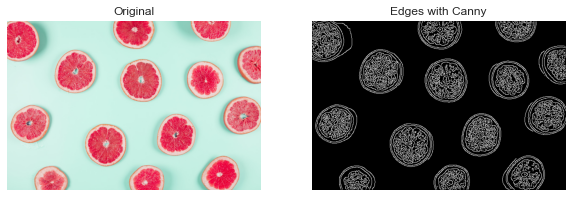

In [7]:
# convert to grayscale
graypfruit = rgb2gray(grapefruit)

# apply canny edge detector
canny_edges = canny(graypfruit)

plot_comparison(grapefruit, canny_edges, 'Edges with Canny')

## Less edgy

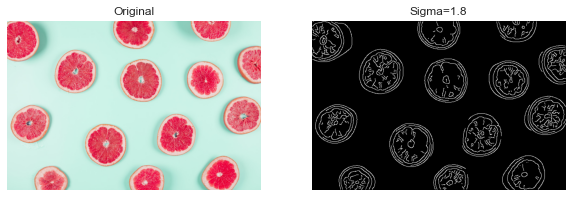

In [8]:
# apply canny edge detector
canny_edges = canny(graypfruit, sigma=1.8)

plot_comparison(grapefruit, canny_edges, 'Sigma=1.8')

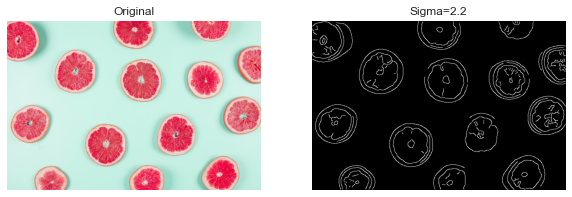

In [9]:
# apply canny edge detector
canny_edges = canny(graypfruit, sigma=2.2)

plot_comparison(grapefruit, canny_edges, 'Sigma=2.2')

# Right around the corner

In [15]:
def show_image_with_corners(image, coords, title='Corners detected', ax=None):
    if ax == None:
        plt.imshow(image, interpolation='nearest', cmap='gray')
        plt.title(title)
        plt.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image, interpolation='nearest', cmap='gray')
        ax.set(title=title)
        ax.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
        ax.axis('off')

## Perspective

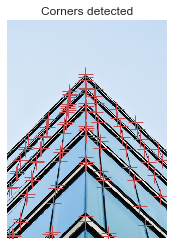

In [14]:
# convert to grayscale
bldg_gray = rgb2gray(bldg)

# apply harris detector
bldg_measure = corner_harris(bldg_gray)

# find peaks
coords = corner_peaks(bldg_measure, min_distance=2)

show_image_with_corners(bldg, coords)

## Less corners

With a min_distance set to 2, we detect a total 98 corners in the image.
With a min_distance set to 40, we detect a total 36 corners in the image.


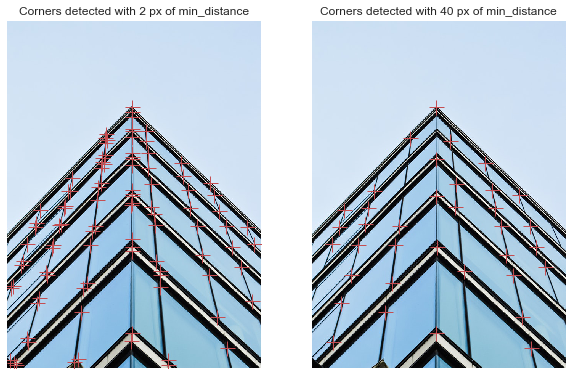

In [17]:
# Find the peaks with a min distance of 2 pixels
coords_w_min_2 = corner_peaks(bldg_measure, min_distance=2)
print(f'With a min_distance set to 2, we detect a total {len(coords_w_min_2)} corners in the image.')

# Find the peaks with a min distance of 40 pixels
coords_w_min_40 = corner_peaks(bldg_measure, min_distance=40)
print(f'With a min_distance set to 40, we detect a total {len(coords_w_min_40)} corners in the image.')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

show_image_with_corners(bldg, coords_w_min_2, "Corners detected with 2 px of min_distance", ax=ax1)
show_image_with_corners(bldg, coords_w_min_40, "Corners detected with 40 px of min_distance", ax=ax2)

plt.show()

# Face detection

In [21]:
def show_detected_face(result, detected, title='Face image'):
    plt.imshow(result)
    img_desc = plt.gca()
    plt.set_cmap('gray')
    plt.title(title)
    plt.axis('off')
    
    for patch in detected:
        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False, color='r', linewidth=2)
        )
    plt.show()

## Is someone here?

In [23]:
# load pretrained file from skimage
trained_file = data.lbp_frontal_face_cascade_filename()

# initialize detector cascade
detector = Cascade(trained_file)

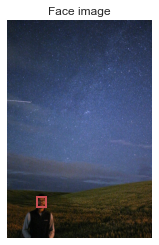

In [27]:
detected = detector.detect_multi_scale(img=night,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(10, 10),
                                       max_size=(200, 200))

show_detected_face(night, detected)

## Multiple faces

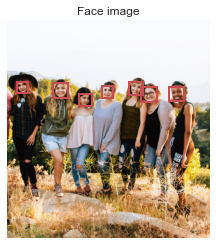

In [30]:
detected = detector.detect_multi_scale(img=friends,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(10, 10),
                                       max_size=(200, 200))

show_detected_face(friends, detected)

## Segmentation and face detection

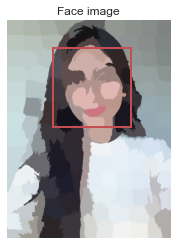

In [33]:
# obtain segmentation with slic
segments = slic(girl, n_segments=150)

girl_segmented = label2rgb(segments, girl, kind='avg')

detected = detector.detect_multi_scale(img=girl_segmented,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(10, 10),
                                       max_size=(1000, 1000))

show_detected_face(girl_segmented, detected)

# Real-world applications

In [43]:
def getFace(d, image):
    x, y = d['r'], d['c']
    
    width, height = d['r'] + d['width'], d['c'] + d['height']
    
    face = image[x:width, y:height]
    return face

def mergeBlurryFace(original, gaussian_image):
    x, y = d['r'], d['c']
    
    width, height = d['r'] + d['width'], d['c'] + d['height']
    
    original[x:width, y:height, :] = gaussian_image
    return original

## Privacy protection

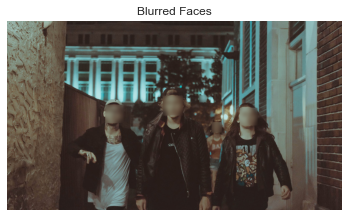

In [50]:
# detect faces
detected = detector.detect_multi_scale(img=ppl,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(10, 10),
                                       max_size=(100, 100))

# blur each face
resulting_image = ppl.copy() / 255
for d in detected:
    face = getFace(d, ppl)
    
    # apply gaussian filter
    face_blurred = gaussian(face, 
                            multichannel=True, 
                            sigma=8)
    
    # merge with original
    resulting_image = mergeBlurryFace(resulting_image, face_blurred)

show_image(resulting_image, 'Blurred Faces')

## Help Sally restore here graduation photo

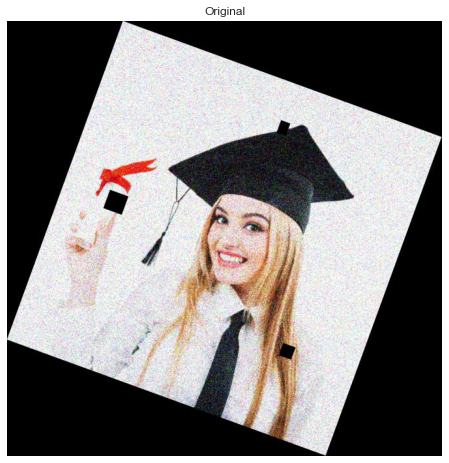

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))

show_image(sally, 'Original',ax=ax)

plt.show()

In [73]:
# rotate image
upright_img = rotate(sally, 20)

# denoise by total variation
upright_img_wo_noise = denoise_tv_chambolle(upright_img,
                                            weight=0.1,
                                            multichannel=True)

# reconstruct missing parts
mask = np.zeros(sally.shape[:-1])
mask[320:360,140:175] = 1
mask[130:160,350:370] = 1
mask[450:475,470:495] = 1

result = inpaint.inpaint_biharmonic(upright_img_wo_noise, mask,
                                    multichannel=True)

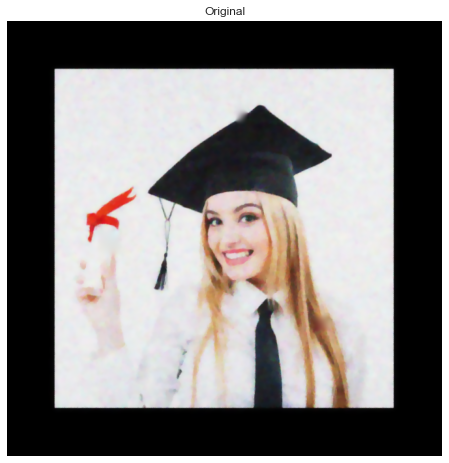

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))

show_image(result, 'Original',ax=ax)

plt.show()